# description

make the case of interpreting a DL functional model 

using data which is not structured like an (numpy) array.

instead the data is hold in a list container wrapping multiple 3-d arrays with different shape

# some setup

In [1]:
from tlmisc.utils.gpu_assignment import gpu_assignment
gpu_assignment([1])

Using TensorFlow backend.


In [2]:
import numpy as np
import keras as k
from keras.layers import *
import shap
import pandas as pd

def model_summary(model):
    
    # print structure and number of parameters
    ##########################################
    print(model.summary())

    # plot net structure
    ####################
    from keras.utils.vis_utils import plot_model
    from IPython.display import Image, display
    
    fname = 'model_plot_tmp.png'    
    plot_model(model, to_file=fname, show_shapes=True, show_layer_names=True)        
    display(Image(filename=fname))
    
    return None


# multi modal sample data

3d: nobs x time x nfeat

In [3]:
nobs = 100
nfeat1 = 10
nfeat2 = 20
time = 25
X1 = np.random.normal(size=nobs*time*nfeat1).reshape((nobs,time,nfeat1))
X2 = np.random.normal(size=nobs*time*nfeat2).reshape((nobs,time,nfeat2))

y = np.random.normal(size=nobs, loc=2, scale = 2)
print("shape X1 = %s" %str(X1.shape))
print("shape X2 = %s" %str(X2.shape))
print(X1.__class__)



shape X1 = (100, 25, 10)
shape X2 = (100, 25, 20)
<class 'numpy.ndarray'>


# functional model with multiple inputs

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X1 (InputLayer)                 (None, 25, 10)       0                                            
__________________________________________________________________________________________________
X2 (InputLayer)                 (None, 25, 20)       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 25, 5)        55          X1[0][0]                         
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 25, 7)        147         X2[0][0]                         
__________________________________________________________________________________________________
concatenat

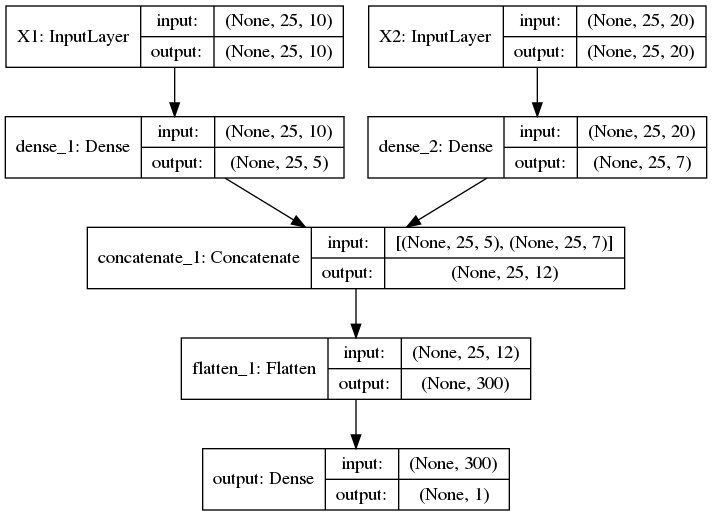

In [4]:
# model
actfun = "tanh"
X1_input = k.Input(shape=X1.shape[1:], name = "X1")
X1_d = Dense(5, activation = actfun)(X1_input)

X2_input = k.Input(shape=X2.shape[1:], name = "X2")
X2_d = Dense(7, activation = actfun)(X2_input)

X1X2 = concatenate([X1_d, X2_d])
X1X2 = Flatten()(X1X2)
output = Dense(1, activation = actfun, name = "output")(X1X2)

# initialize model
model = k.models.Model(inputs = [X1_input, X2_input], outputs=output)

# compile model
model.compile(optimizer = "nadam",
             loss = "mse", 
             metrics = ["mse"])   
model_summary(model)

In [5]:
model.fit(x=[X1,X2], 
          y = y, 
          batch_size = 8, 
          epochs = 8 )

Epoch 1/8
100/100 [==============================] - 1s 7ms/step - loss: 7.6291 - mean_squared_error: 7.6291
Epoch 2/8
100/100 [==============================] - 0s 677us/step - loss: 6.8525 - mean_squared_error: 6.8525
Epoch 3/8
100/100 [==============================] - 0s 684us/step - loss: 6.1995 - mean_squared_error: 6.1995
Epoch 4/8
100/100 [==============================] - 0s 653us/step - loss: 5.7036 - mean_squared_error: 5.7036
Epoch 5/8
100/100 [==============================] - 0s 689us/step - loss: 5.3676 - mean_squared_error: 5.3676
Epoch 6/8
100/100 [==============================] - ETA: 0s - loss: 4.6932 - mean_squared_error: 4.69 - 0s 645us/step - loss: 5.1081 - mean_squared_error: 5.1081
Epoch 7/8
100/100 [==============================] - 0s 651us/step - loss: 4.9047 - mean_squared_error: 4.9047
Epoch 8/8
100/100 [==============================] - 0s 680us/step - loss: 4.7235 - mean_squared_error: 4.7235


In [6]:
# get average model prediction
pred = model.predict(x=[X1,X2])
pred1 = pred[0] # prediction of obs 0
pred2 = pred[1] # prediction of obs 1
avgPred = np.mean(pred)
print("average prediction over all observations = %s" %avgPred)
print("prediction of obs1 = %s" %pred1)
print("prediction of obs2 = %s" %pred2)

average prediction over all observations = 0.486447
prediction of obs1 = [-0.95991451]
prediction of obs2 = [ 0.94736129]


# SHAP

In [7]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
X = [X1,X2]
explainer = shap.DeepExplainer(model, data = X)
# shap_values = explainer.shap_values(X)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])



In [8]:
print(len(shap_values))
print(len(shap_values[0]))
print(shap_values[0][0].shape)
print(shap_values[0][1].shape)
print(shap_values[0][1][0,:].shape)


1
2
(100, 25, 10)
(100, 25, 20)
(25, 20)


## multiple observations

### 1st observation

#### 1st input

In [9]:
# force plot of X1 input related features
shap.force_plot(explainer.expected_value, shap_values[0][0][0,:], X[0][0,:]) # numpy

#### 2nd input

In [10]:
# force plot of X1 input related features
# 1st observation
shap.force_plot(explainer.expected_value, shap_values[0][1][0,:], X[1][0,:]) # numpy
# shap.force_plot(explainer.expected_value, shap_values[0][1][0,:], X[1].iloc[0]) # pandas

## 2nd observation

#### 1st input domain

In [11]:
# force plot of X1 input related features
# 2nd observation
shap.force_plot(explainer.expected_value, shap_values[0][0][1,:], X[0][1,:]) # numpy
# shap.force_plot(explainer.expected_value, shap_values[0][0][1,:], X[0].iloc[1]) # pandas

#### 2nd input domain

In [12]:
# force plot of X1 input related features
# 2nd observation
# force plot with values
shap.force_plot(explainer.expected_value, shap_values[0][1][1,:], X[1][1,:]) # numpy

#### shapley additive explanations of the 2nd observation output

In [13]:
print("baseline prediction %s" %str(explainer.expected_value[0]))
print("\n")
print("1st domains contribution (shift from baseline): %s" %str(np.sum(shap_values[0][0][1,:])))
print("2nd domains contribution (shift from baseline): %s" %str(np.sum(shap_values[0][1][1,:])))
s = np.sum(shap_values[0][0][1,:]) + np.sum(shap_values[0][1][1,:])
print("SUM of both domains contribution: %s" %str(s))
print("\n")
print("SUM of both domains contribution + baseline: %s" %str(s + explainer.expected_value[0]))
print("actual prediciton: %s" %str(pred2))


baseline prediction 0.486447


1st domains contribution (shift from baseline): 0.208964392782
2nd domains contribution (shift from baseline): 0.251949849033
SUM of both domains contribution: 0.460914241815


SUM of both domains contribution + baseline: 0.947361278082
actual prediciton: [ 0.94736129]


##### 2nd input domain, but only labels without values

In [14]:
# force plot of X1 input related features
# 2nd observation
# force plot w/o values
shap.force_plot(explainer.expected_value, shap_values[0][0][1,:]) # numpy


### both input domains
#### but only labels without values

In [15]:
# force plot of X1 input and X2 input related features
# 2nd observation
sv_x1 = shap_values[0][0][1,:]
sv_x2 = shap_values[0][1][1,:]
sv = np.c_[sv_x1, sv_x2]
shap.force_plot(explainer.expected_value, sv)

#### with values

In [16]:
# force plot of X1 input and X2 input related features
# 2nd observation
sv = np.c_[shap_values[0][0][1,:], shap_values[0][1][1,:]]
sv_x = np.c_[X[0][1,:], X[1][1,:]]
shap.force_plot(explainer.expected_value, sv, sv_x)

### both input domains
### with custom feature names + with values

In [17]:
# get feature names
# shape must be equal to sv.shape
f1 = ["X1_" + str(i) for i in range(X1.shape[2])]
f2 = ["X2_" + str(i) for i in range(X2.shape[2])]
feature_names = f1+f2


In [18]:
shap.force_plot(explainer.expected_value, sv, sv_x, feature_names = feature_names)

# TODO: Aggregation

In [19]:
# find an approach to visualize aggregated shap values 
# in order to be able to focus on high level details like domains and subdomains.
# - aggregate over time
# - aggregate over all instances of a subdomain

## aggregate over time -> SHAP dependency plot

* shap values: aggregation via cumulation (-> additive explanation)
* features: aggregation via averaging

In [20]:
# time
print(shap_values[0][0].shape)
print(shap_values[0][1].shape)

sv_aggr_dom1 = np.sum(shap_values[0][0], 1)
sv_aggr_dom2 = np.sum(shap_values[0][1], 1)

print(sv_aggr_dom1.shape)
print(sv_aggr_dom2.shape)

(100, 25, 10)
(100, 25, 20)
(100, 10)
(100, 20)


In [21]:
# features
print(X[0].shape)
print(X[1].shape)

X_aggr_dom1 = np.mean(X[0], 1)
X_aggr_dom2 = np.mean(X[1], 1)

print(X_aggr_dom1.shape)
print(X_aggr_dom2.shape)

X_aggr_dom1 = pd.DataFrame(X_aggr_dom1, columns = ["X1_" + str(i+1) for i in range(X_aggr_dom1.shape[1])])
X_aggr_dom2 = pd.DataFrame(X_aggr_dom2, columns = ["X2_" + str(i+1) for i in range(X_aggr_dom2.shape[1])])


(100, 25, 10)
(100, 25, 20)
(100, 10)
(100, 20)


if the feature matrix is a pandas data frame with namend columns,
then the plots will be labeled automatically

In [22]:
X_aggr = pd.concat([X_aggr_dom1.reset_index(drop=True), X_aggr_dom2], axis=1)

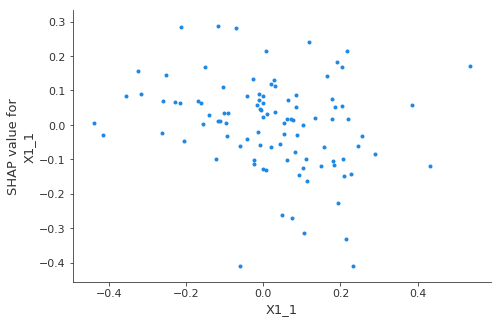

In [23]:
shap.dependence_plot(0, 
                     np.c_[sv_aggr_dom1, sv_aggr_dom2], 
                     X_aggr, 
                     interaction_index=None)

# summary plots



the inbuilt method to plot summary shap values can't handle data with >2 dimension in a plausible way.

because otherwise summary plots (aggregated VS not aggregated) would have the same pattern.

this is not the case, see below.

## no aggregation

data in original format, 3 dimensions (obs x time x feature).


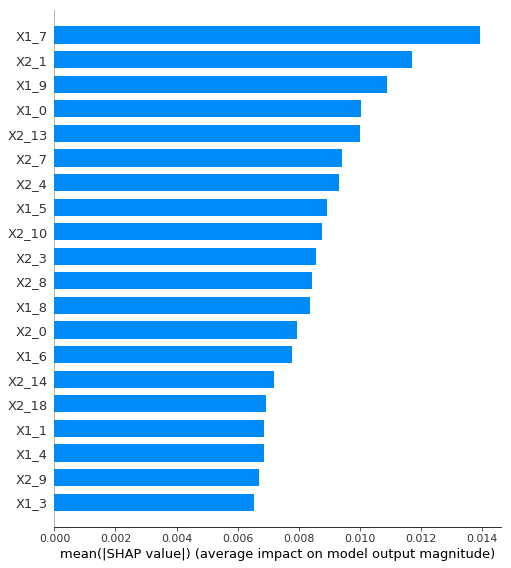

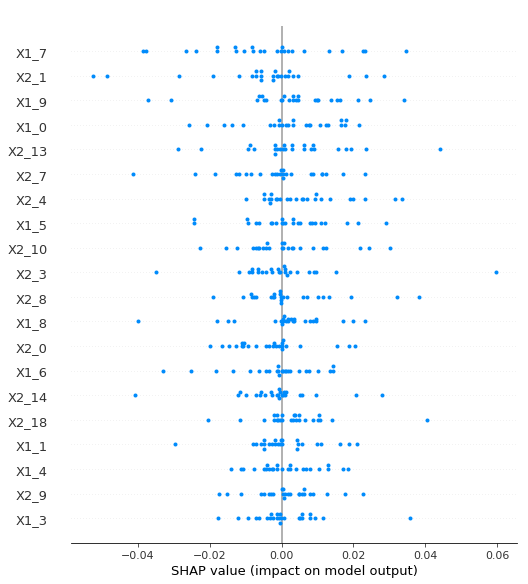

In [24]:
shap.summary_plot(sv, X, plot_type="bar", feature_names=feature_names)
shap.summary_plot(sv, X, feature_names=feature_names)

## aggregation

aggregated over time

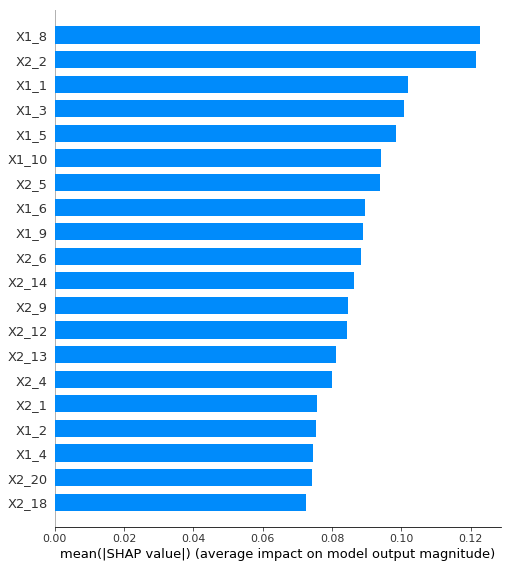

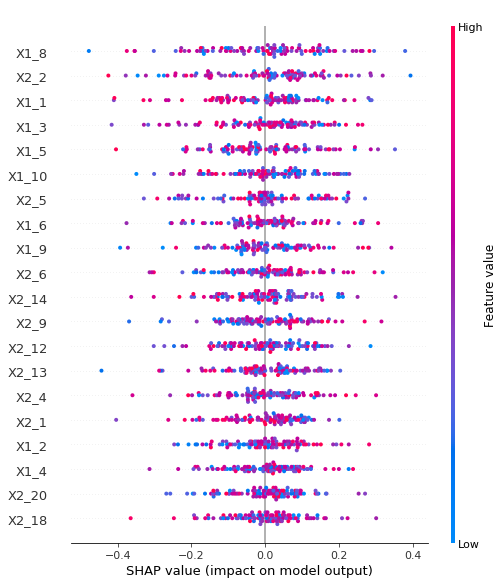

In [25]:
shap.summary_plot(np.c_[sv_aggr_dom1, sv_aggr_dom2], X_aggr, plot_type = "bar")

shap.summary_plot(np.c_[sv_aggr_dom1, sv_aggr_dom2], X_aggr)

# dependency plot, accumulated local effects

dependcy plot should only be applied to cumulated values so that
the input matrices have 2 dims.

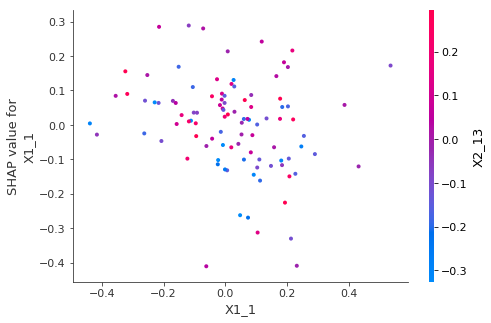

In [26]:
shap.dependence_plot(0, 
                     np.c_[sv_aggr_dom1, sv_aggr_dom2], 
                     X_aggr)

# TODO